In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
import pickle



import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

In [2]:
df = pd.read_csv('card_transdata.csv')
df.head()


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


- **distance_from_home** = the distance from home where the transaction happened.

- **distance_from_last_transaction** = the distance from last transaction happened.

-  **ratio_to_median_purchase_price** = Ratio of purchased price transaction to median purchase price.

- **repeat_retailer** = Is the transaction happened from same retailer (1 = Yes, 0 = No)

- **used_chip** = Is the transaction through chip (credit card). (1 = Yes, 0 = No)

- **used_pin_number** = Is the transaction happened by using PIN number. (1 = Yes, 0 = No)

- **online_order** = Is the transaction an online order. (1 = Yes, 0 = No)

- **fraud** = Is the transaction fraudulent. (1 = Yes, 0 = No)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [4]:
df.isna().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

        count  Percentage (%)
fraud                        
0.0    912597         91.2597
1.0     87403          8.7403


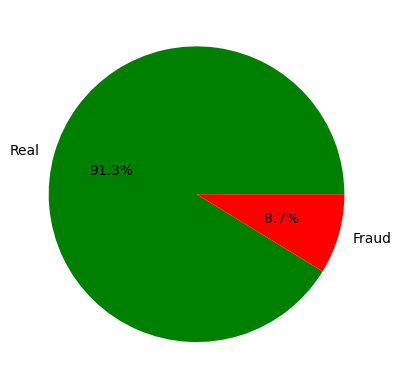

In [5]:
fraud_count = df['fraud'].value_counts()
fraud_Pct = df['fraud'].value_counts(normalize = True) * 100

fraud_sum = pd.DataFrame({
    'count' : fraud_count,
    'Percentage (%)' : fraud_Pct
})

print(fraud_sum)

#Pie chart
fraud_count.plot.pie(autopct = "%.1f%%", labels =['Real', 'Fraud'], colors = ['green','red'])
plt.ylabel('')
plt.show()


There are 912597 non fraud datapoints (91.3%) and 87403 fraud datapoints (8.7%). This will lead to a class imbalance problem when forming our models
 - As When training a machine learning model on imbalanced data, the model may become biased towards the majority class (non-fraud). This happens because the model sees far more examples of non-fraudulent transactions and thus learns to predict non-fraud more often. As a result, the model might have high overall accuracy but perform poorly on the minority class (fraud).


- High accuracy can be misleading because the model might simply predict the majority class most of the time. For example, if a model predicts "non-fraud" for every transaction, it would be correct 91.3% of the time, but it wouldn't be detecting fraud effectively.

- With a balanced dataset, evaluation metrics such as precision, recall, F1-score, and AUC-ROC curve become more meaningful. These metrics provide a better understanding of how well the model is performing, especially on the minority class (fraud).

- We dont need to worry much about under sampling, even though the Non fraud data has reduced from 912597 to 87403. 87403 is still a large amount of data points to train. Hence the benefits outweigh the drawbacks of resampling 

**Hence we will resample the dataset with 87403 datapoints for both fraud classes.**

In [6]:
real = df[df["fraud"] == 0]
fraud = df[df["fraud"] == 1]

real_sample = real.sample(n = 87403, random_state = 42 )
fraud_sample = fraud.sample(n = 87403, random_state = 42)

df1 = pd.concat([real_sample, fraud_sample], axis = 0)

       count  Percentage (%)
fraud                       
0.0    87403            50.0
1.0    87403            50.0


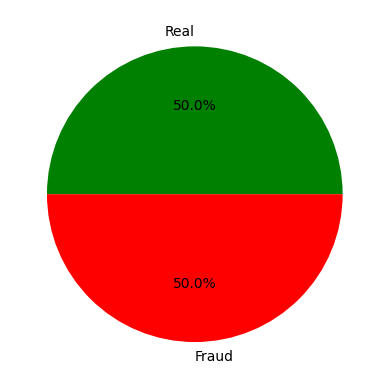

In [7]:
true_fraud_count = df1['fraud'].value_counts()
true_fraud_Pct = df1['fraud'].value_counts(normalize = True) * 100

true_fraud_sum = pd.DataFrame({
    'count' : true_fraud_count,
    'Percentage (%)' : true_fraud_Pct
})

print(true_fraud_sum)

#Pie chart
true_fraud_count.plot.pie(autopct = "%.1f%%", labels =['Real', 'Fraud'], colors = ['green','red'])
plt.ylabel('')
plt.show()

# Regression model

### ANOVA

In [8]:
ols_data = df1[['distance_from_home','distance_from_last_transaction',
                'ratio_to_median_purchase_price','repeat_retailer',
                'used_chip','used_pin_number','online_order','fraud'
]]

In [9]:
ols_formula = " fraud ~ distance_from_home + distance_from_last_transaction + ratio_to_median_purchase_price + repeat_retailer + used_chip + used_pin_number + online_order"

In [10]:
#Build OLS, fit the model to data

OLS = ols(formula = ols_formula, data = ols_data)
model = OLS.fit()  

# Get summary statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  fraud   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                 1.959e+04
Date:                Thu, 29 Aug 2024   Prob (F-statistic):               0.00
Time:                        14:52:17   Log-Likelihood:                -76256.
No. Observations:              174806   AIC:                         1.525e+05
Df Residuals:                  174798   BIC:                         1.526e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.0762      0.003     24.091      0.000       0.070       0.082
distance_from_home                 0.0010    8.7e-06    118.360      0.000       0.001       0.001
distance_from_last_transaction     0.0015   2.34e-05     64.961      0.000       0.001       0.002
ratio_to_median_purchase_price     0.0469      0.000    244.700      0.000       0.047       0.047
repeat_retailer                   -0.0606      0.003    -21.622      0.000      -0.066      -0.055
used_chip                         -0.0972      0.002    -49.775      0.000      -0.101      -0.093
used_pin_number                   -0.3411      0.004    -87.753      0.000      -0.349      -0.333
online_order                       0.3736      0.002    168.744      0.000       0.369       0.378
==============================================================================
Omnibus:                    56925.124   Durbin-Watson:                   0.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1406333.347
Skew:                          -1.013   Prob(JB):                         0.00
Kurtosis:                      16.747   Cond. No.                         524.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared: 0.440
- This means that 44% of the variance in the dependent variable (fraud) is explained by the independent variables in the model. This is a measure of the model's explanatory power.

Adj. R-squared: 0.440
- The adjusted R-squared is the same as R-squared here because you have not added or removed predictors. It adjusts for the number of predictors in the model and is used to evaluate the goodness of fit for multiple regression models.

F-statistic: 1.959e+04
- This statistic tests the overall significance of the model. The high value suggests that the model is statistically significant.

Prob (F-statistic): 0.00
- This p-value indicates that the model is significant at the 0.05 level (in fact, it's much smaller). This means that at least one of the predictors is significantly related to the dependent variable.
Model Fit Statistics

Log-Likelihood: -76256.
- This is the log of the likelihood function for the fitted model. It is used for model comparison and selection.

AIC (Akaike Information Criterion): 1.525e+05
- AIC is used for model comparison; lower values indicate a better fit, taking into account the number of predictors.

BIC (Bayesian Information Criterion): 1.526e+05
- Similar to AIC, BIC also considers the number of predictors but penalizes more heavily for additional parameters.




**Coefficients**



distance_from_home: 0.0010
- For each unit increase in distance_from_home, the fraud value increases by 0.0010, holding other variables constant. The coefficient is statistically significant with a very low p-value.

distance_from_last_transaction: 0.0015
- For each unit increase in distance_from_last_transaction, fraud increases by 0.0015, holding other variables constant. The coefficient is statistically significant.

ratio_to_median_purchase_price: 0.0469
- For each unit increase in the ratio to median purchase price, fraud increases by 0.0469, holding other variables constant. The coefficient is statistically significant.

repeat_retailer: -0.0606
- For each unit increase in repeat_retailer, fraud decreases by 0.0606, holding other variables constant. The coefficient is statistically significant.

used_chip: -0.0972
- For each unit increase in used_chip, fraud decreases by 0.0972, holding other variables constant. The coefficient is statistically significant.

used_pin_number: -0.3411
- For each unit increase in used_pin_number, fraud decreases by 0.3411, holding other variables constant. The coefficient is statistically significant.

online_order: 0.3736
- For each unit increase in online_order, fraud increases by 0.3736, holding other variables constant. The coefficient is statistically significant


In [11]:
# Run one way ANOVA

sm.stats.anova_lm(model, typ = 2)  #different types 1,2,3

,sum_sq,df,F,PR(>F)
distance_from_home,1962.737438,1.0,14009.111382,0.000000e+00
distance_from_last_transaction,591.234856,1.0,4219.960750,0.000000e+00
ratio_to_median_purchase_price,8389.152346,1.0,59877.886531,0.000000e+00
repeat_retailer,65.500119,1.0,467.509532,1.526907e-103
used_chip,347.109749,1.0,2477.508727,0.000000e+00
used_pin_number,1078.877689,1.0,7700.529587,0.000000e+00
online_order,3989.411658,1.0,28474.573916,0.000000e+00
Residual,24489.960096,174798.0,NaN,NaN


The p-values are very small (essentially zero), suggesting that the coefficients for these variables are statistically significant. In other words, there is a very low probability that these variables' coefficients are zero (i.e., they have a significant impact on the dependent variable).

**given that all the variables in your OLS regression model are statistically significant , we can confidently proceed to use  machine learning models for further analysis**

### Logistic regression
- As logistic regression is used when the target variable is binary (e.g 0 or 1), hence it is suitable for out target variable 'fraud'

In [12]:
X = np.array(df1.drop(columns = "fraud"))
y = np.array(df1["fraud"])


In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

#Fit and predict 
clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)

d:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Make a table to compare scores between models easier later on

In [14]:
def make_results(model_name, model, X_test, y_test):

    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Create table of results
    table = pd.DataFrame({
        'Model': [model_name],
        'F1': [f1],
        'Recall': [recall],
        'Precision': [precision],
        'Accuracy': [accuracy],
        'ROC AUC': [roc_auc]
    })

    return table

In [15]:
LogR_results = make_results('Log Reg', clf, X_test, y_test)
LogR_results

,Model,F1,Recall,Precision,Accuracy,ROC AUC
0,Log Reg,0.941029,0.947866,0.934291,0.940601,0.979185


**F1 Score: 0.941029**
- A high F1 score (close to 1) indicates that the model is performing well in terms of both precision and recall, meaning it has a good balance between identifying true frauds (recall) and avoiding false fraud alerts (precision).



**Recall: 0.947866**
- A recall of 0.947866 means that approximately 94.79% of the actual fraud cases were correctly classified by the model.
- High recall is crucial in fraud detection because you want to minimize the number of fraudulent transactions that go undetected.

**Precision: 0.934291**
- A precision of 0.934291 indicates that about 93.43% of the transactions flagged as fraudulent by the model were indeed fraudulent.
- High precision is important to avoid too many false alarms, where non-fraudulent transactions are incorrectly flagged as fraud.

**Accuracy: 0.940601**
- An accuracy of 0.940601 means that about 94.06% of all transactions were correctly classified by the model.

**ROC AUC: 0.979185**
- A ROC AUC of 0.979185 indicates that the model has a very good ability to discriminate between fraudulent and non-fraudulent transactions. A value of 1 represents perfect classification, while 0.5 represents random guessing.

In [16]:
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94     26221
         1.0       0.93      0.95      0.94     26221

    accuracy                           0.94     52442
   macro avg       0.94      0.94      0.94     52442
weighted avg       0.94      0.94      0.94     52442



**Precision**
- Class 0.0 (Non-Fraud): 0.95 precision means that 95% of the transactions predicted as non-fraudulent were indeed non-fraudulent.
- Class 1.0 (Fraud): 0.93 precision means that 93% of the transactions predicted as fraudulent were indeed fraudulent.

**Recall**
- Class 0.0 (Non-Fraud): 0.93 recall means that 93% of actual non-fraudulent transactions were correctly identified by the model.
- Class 1.0 (Fraud): 0.95 recall means that 95% of actual fraudulent transactions were correctly identified by the model.

**Accuracy**
- The model has an overall accuracy of 94%, meaning that it correctly classifies a large majority of transactions.

**Hence this logistic regression model performs consistently well across both classes, with precision, recall, Accuracy and F1-scores all around 0.94 for both non-fraudulent and fraudulent transactions. indicating that this model is effective at identifying both fraudulent and non-fraudulent transactions while maintaining a low rate of false positives and false negatives, which is crucual in fraud cases**

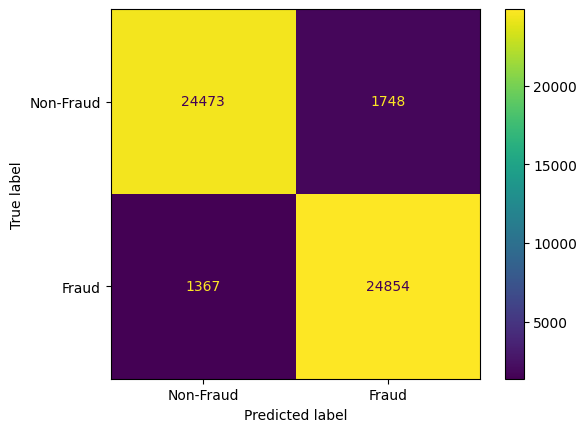

In [40]:
cm = metrics.confusion_matrix(y_test, y_pred, labels = clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = ['Non-Fraud', 'Fraud'])
disp.plot()
plt.show()

- True Negatives (TN) = 24472
- False Positives (FP) = 1748
- False Negatives (FN) = 1367
- True Positives (TP) = 24854

- False Alarms: There are 1748 false positives, meaning that some legitimate transactions are being flagged as fraudulent.
- Missed Fraud Cases: The model misses 1367 fraudulent transactions, which are important to minimize in a real-world setting.

Overall, this confusion matrix shows the  model is effectively identifying both fraudulent and non-fraudulent transactions with a good balance between precision and recall. But it can be improved

Next we will look at a Random Forest model to see if it can perform better

### Random Forest Model

In [18]:
%%time

rf = RandomForestClassifier(random_state = 0)

cv_params = {'max_depth': [2,3,4,5, None],   # set hyperparemeters and values
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100, 125, 150]
             }  

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']  # Metrics model will capture

rf_cv = GridSearchCV(rf, cv_params, scoring = scoring, cv = 5, refit = 'f1') # Start GridSearch

rf_cv.fit(X_train, y_train)  # fit model to training data

d:\Python\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


CPU times: total: 4h 6min
Wall time: 4h 6min 44s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [2, 3, 4, 5, None],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [75, 100, 125, 150]},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [20]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

In [32]:
rf_cv.best_score_

np.float64(0.9999427940992106)

The score from best_score_ reflects the model’s performance on the training data during cross-validation.

This is the best mean score achieved during cross-validation using the GridSearchCV process. The score 0.9999427940992106 is extremely high, indicating that the model performed exceptionally well on the training folds of the cross-validation.

In [28]:
def make_results_gs(model_name, model_object, X_test, y_test):
    '''
    Accepts as arguments a model name  anda fit GridSearchCV model object.

    Returns a pandas df with the F1, recall, precision, accuracy, ROC AUC scores
    for the model with the best mean F1 score across all validation folds.
    '''

    
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    
    best_model_rf = model_object.best_estimator_

    #Predict on test set
    y_test_pred_rf = best_model_rf.predict(X_test)
    y_test_proba_rf = best_model_rf.predict_proba(X_test)[:, 1]

    # Find ROC AUC sCORE
    roc_auc = roc_auc_score(y_test, y_test_proba_rf)

    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy],
                          'ROC AUC' : [roc_auc]
                         }
                        )

    return table

In [30]:
# Form table
rf_cv_results = make_results_gs('Random Forest', rf_cv, X_test, y_test)
rf_cv_results


,Model,F1,Recall,Precision,Accuracy,ROC AUC
0,Random Forest,0.999943,0.999967,0.999918,0.999943,1.0


- The best score from the test set metrics being as high as the cross-validation metrics is a positive indicator. It suggests that the model generalizes well and is not overfitting.

- 

In [31]:
# Join tables
results = pd.concat([rf_cv_results, LogR_results])
results

,Model,F1,Recall,Precision,Accuracy,ROC AUC
0,Random Forest,0.999943,0.999967,0.999918,0.999943,1.000000
0,Log Reg,0.941029,0.947866,0.934291,0.940601,0.979185


- Random Forest outperforms Logistic Regression across all metrics, especially in ROC AUC, which is perfect for Random Forest.
- The Random Forest model shows almost perfect classification, indicating it might be overfitting, especially if these results are on training data rather than a held-out test set.

- **There is minimal chances of data leakages as we ensured the model training and hyperparameter tuning is only done on training data. And the test set was only used for final evaluation and not during the taining or cross validation phases**

**Check feature importance**

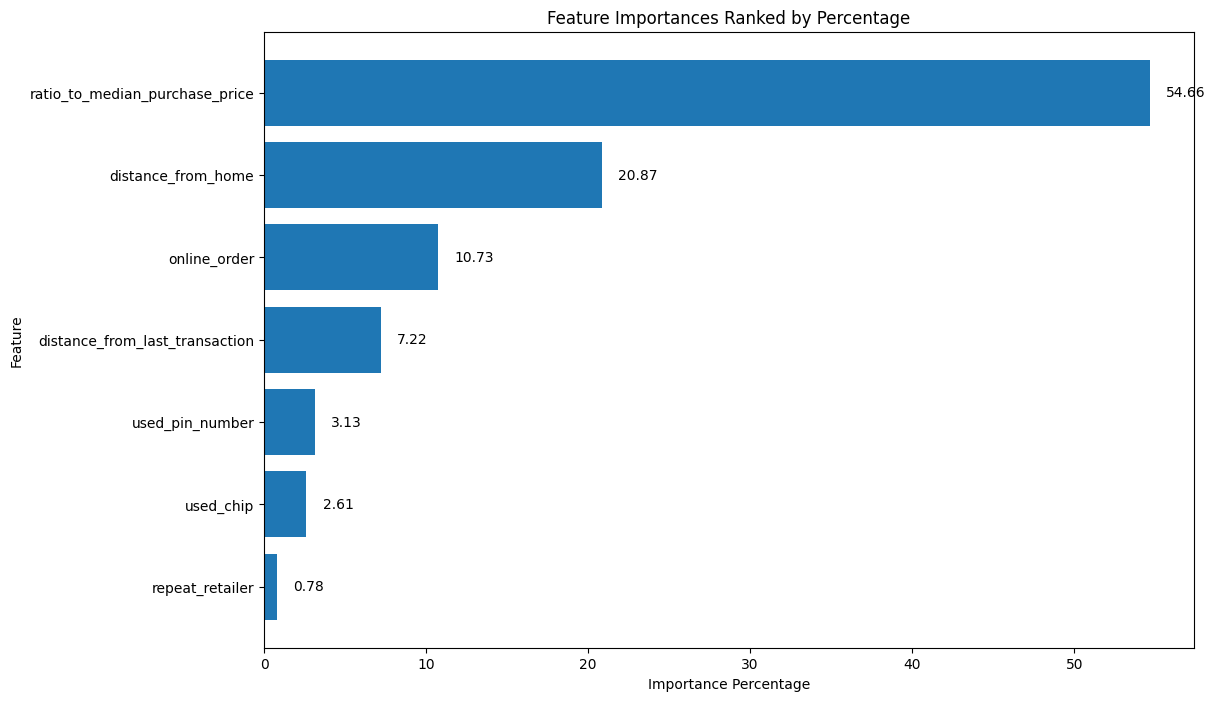

In [37]:
best_model_rf = rf_cv.best_estimator_
importance_rf = best_model_rf.feature_importances_

feature_names = [
    'distance_from_home',
    'distance_from_last_transaction',
    'ratio_to_median_purchase_price',
    'repeat_retailer',
    'used_chip',
    'used_pin_number',
    'online_order'
]

# Create a DataFrame for feature importances
importance_rf_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_rf
})


importance_rf_df = importance_rf_df.sort_values(by='Importance', ascending=False)
total_importance = importance_rf_df['Importance'].sum()
importance_rf_df['Importance(%)'] = (importance_rf_df['Importance'] / total_importance) * 100


# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_rf_df['Feature'], importance_rf_df['Importance(%)'])
plt.xlabel('Importance Percentage')
plt.ylabel('Feature')
plt.title('Feature Importances Ranked by Percentage')
plt.gca().invert_yaxis()

# Annotate bars 
for i, (v, feature) in enumerate(zip(importance_rf_df['Importance(%)'], importance_rf_df['Feature'])):
    plt.text(v + 1, i, f'{v:.2f}', color='black', ha='left', va='center')

plt.show()

**ratio_to_median_purchase_price (54.66%)**
- This feature is the most significant predictor in this model , accounting for over half of the importance. This suggests that the ratio of the transaction amount to the median purchase price is a key factor in detecting fraud. Transactions that deviate significantly from typical purchase amounts are likely flagged as fraudulent.

**distance_from_home (20.87%)**
- This feature is also highly important. The distance from the customer's home to the transaction location plays a significant role in fraud detection. A larger distance between the current transaction and the customer's home can be a strong indicator of fraudulent behavior, especially if it's unusually far.

**repeat_retailer (0.78%)**
- The feature indicating whether the retailer is a repeat one is the least important. This suggests that the fact that the retailer is familiar or not has minimal impact on the model’s ability to detect fraud.

**High Importance Features:** ratio_to_median_purchase_price and distance_from_home are the most influential features. They have a major role in predicting fraud, with the purchase amount ratio being the most significant.

**Moderate Importance Features:** online_order and distance_from_last_transaction contribute notably but are less critical than the top two features.

**Low Importance Features:** used_pin_number, used_chip, and repeat_retailer have relatively low importance, suggesting that these features have a smaller impact on fraud detection in your model.

**Confusion matrix**

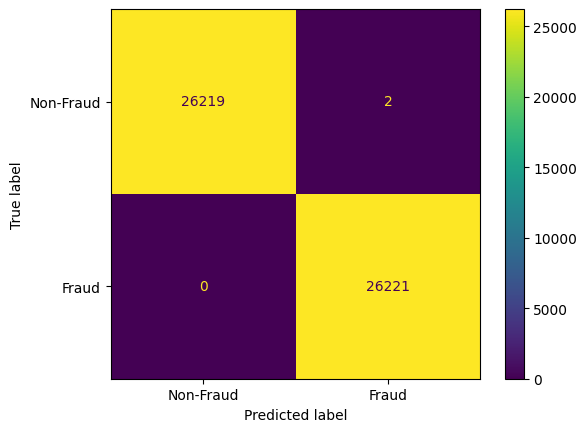

In [39]:
y_pred_rf = best_model_rf.predict(X_test)

cm1 = metrics.confusion_matrix(y_test, y_pred_rf, labels = clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm1 ,display_labels = ['Non-Fraud', 'Fraud'])
disp.plot()
plt.show()

- True Negatives (TN): 26,219
- False Positives (FP): 2
- False Negatives (FN): 0
- True Positives (TP): 26,221

**Overall:**
This random forest model is performing exceptionally well in detecting fraud, with nearly perfect accuracy, precision, recall, and F1 Score. The confusion matrix indicates the model is very effective at both avoiding false positives and not missing any fraudulent cases. This suggests that the model is well-tuned and not overfitting, as it is generalizing well to unseen test data.

**SHAP analysis**
- It helps to understand how features impact model predictions by assigning each feature an importance value.


- Feature importance only provide a single importance score per feature and they do not account for interactions between features and might not capture the complete picture of feature influence.

Hence SHAP plots will give us a better insight as provide a detailed view of how each feature impacts the prediction for each individual observation. They account for feature interactions and are derived from game theory principles, giving a more nuanced view of feature importance.

In [65]:
import shap

best_model_rf = rf_cv.best_estimator_
explainer = shap.TreeExplainer(best_model_rf)

# Calculate SHAP values for the test data (replace X_test with your actual data)
shap_values_class1 = explainer.shap_values(X_test)

# Ensure feature names match
feature_names = [
    'distance_from_home',
    'distance_from_last_transaction',
    'ratio_to_median_purchase_price',
    'repeat_retailer',
    'used_chip',
    'used_pin_number',
    'online_order'
]

# Assuming you want to analyze the SHAP values for class 1 (e.g., fraud)
shap_values_class1 = shap_values[:, :, 0]



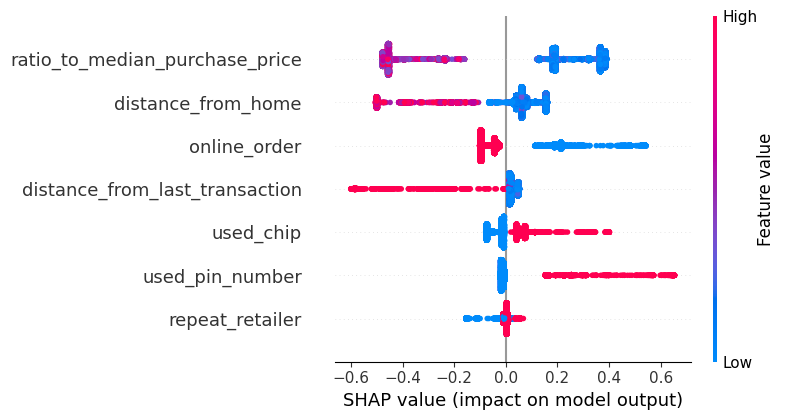

In [82]:
shap.summary_plot(shap_values_class1, X_test, feature_names=feature_names)

The provided SHAP summary plot visually represents how individual features contribute to the model's predictions. Each dot represents a sample in your dataset, and its position on the horizontal axis indicates the feature's impact on the model's output. 


used_pin_number appears to have a significant positive impact on the prediction, indicating that it's a highly influential feature. This is consistent with the fact that it has a high feature importance.

Features such as online order, have a low feature value but a high SHAP value, indicating that the feature still has a signifcant impact on the models predictions. Hence the feature value might not be high but it has a key role in determing the final outcome if the transaction is fraud.

Online orders might be more likely to be fraudulent or legitimate than in-store orders, even if the frequency of online orders is relatively low.
The model might have learned a complex relationship between online_order and other features that influences the prediction.

In [71]:
x_test_df = pd.DataFrame(X_test, columns = feature_names)

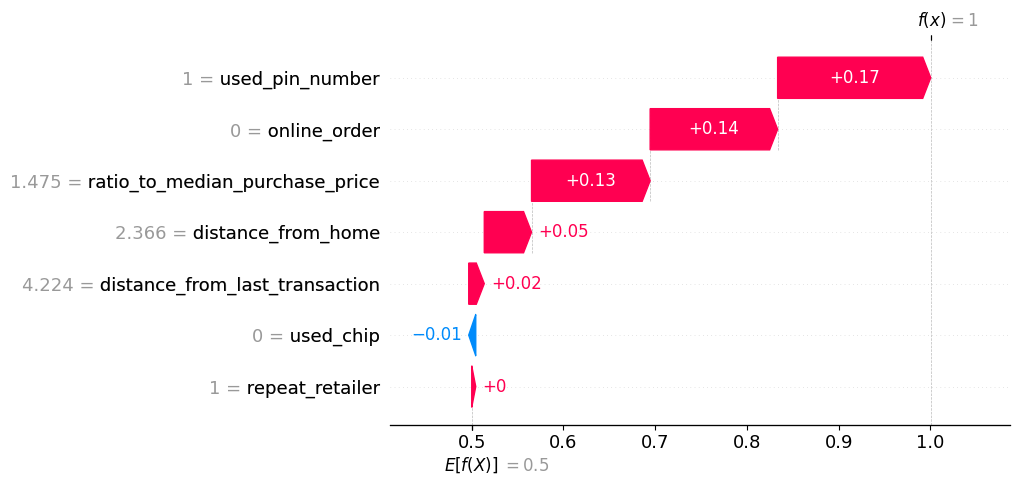

In [79]:
shap.waterfall_plot(shap.Explanation(values=shap_values_class1[0], base_values=explainer.expected_value[1], data=x_test_df.iloc[0], feature_names=feature_names))

The SHAP waterfall plot confirms the findings from the previous analysis: the model's prediction was primarily driven by the use of a PIN number, followed by online orders and the purchase price relative to the median..

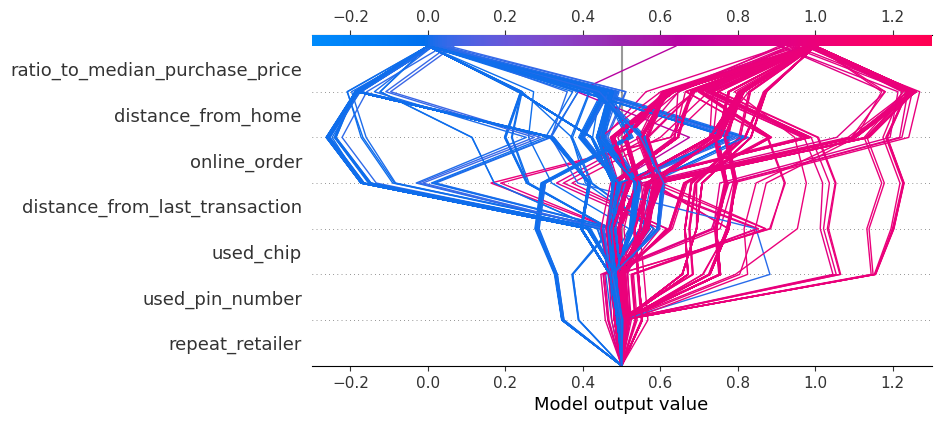

In [85]:
sample_size = 2000

np.random.seed(0)
sample_indices = np.random.choice(x_test_df.index, sample_size, replace = False)
x_test_sample = x_test_df.loc[sample_indices]

shap_values_sample = shap_values_class1[sample_indices]


shap.decision_plot(explainer.expected_value[1], shap_values_sample, x_test_sample, feature_names=feature_names)

The SHAP decision plot provides a visual representation of how individual features contribute to a specific prediction. It shows the base value (the initial prediction without considering any features) and the incremental contributions of each feature to the final prediction.

- Based on the SHAP decision plot, the model's prediction was primarily driven by the use of a PIN number, followed by the ratio median purchase price and the distance from home. The other features had minimal influence on the final outcome.

- In the SHAP decision plot, used pinnumber is indeed a highly influential feature, as indicated by its significant positive impact on the prediction. The concentration of its values on the right side further supports this conclusion.

- Similiary Online order, ratio to median purchase price and distance from home have large cocentrations on the right hand side. Showing a positive impact on prediction on a fraud transaction 

**Based on the SHAP analysis, the model's predictions are primarily influenced by used_pin_number, online_order, and ratio_to_median_purchase_price. These features appear to be strong indicators of fraudulent activity. While distance_from_home and distance_from_last_transaction have some impact, their influence is relatively limited. Other features, such as used_chip and repeat_retailer, have minimal or no effect on the model's predictions. This suggests that the model is primarily focusing on factors related to transaction security and purchase patterns to identify potential fraud cases.**

## Conclusion

The Random Forest model has demonstrated exceptional performance in detecting fraudulent transactions, with a high degree of accuracy and effective identification of key fraud indicators. The analyses conducted, including feature importance and SHAP, have provided valuable insights into which features drive the model’s predictions. The key features identified—such as ratio to median purchase price, online order, and pin number—are crucial for understanding fraud patterns and can guide further model development and operational strategies. By leveraging these insights, the fraud detection system can be refined to enhance its accuracy and efficiency in identifying fraudulent transactions.
